Using TensorFlow backend.


0.0 1.0
('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 39200)         3959200     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 39200)         156800      dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 39200)         0           batchnormalization_1[0][0]   

  0%|          | 0/6000 [00:00<?, ?it/s]

Accuracy: 100.00 pct (20000 of 20000) right


 17%|█▋        | 999/6000 [16:20<1:21:07,  1.03it/s]

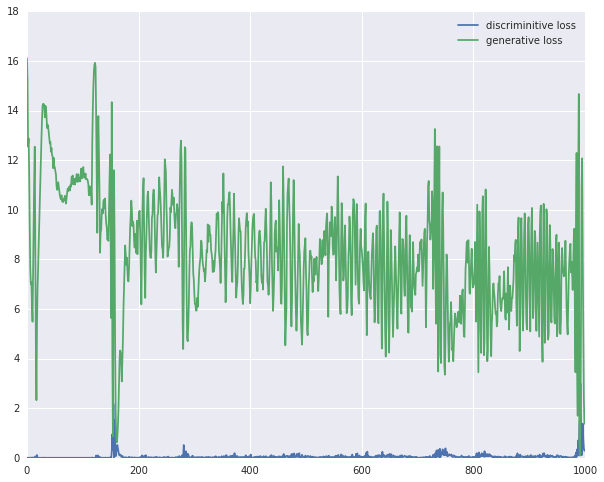

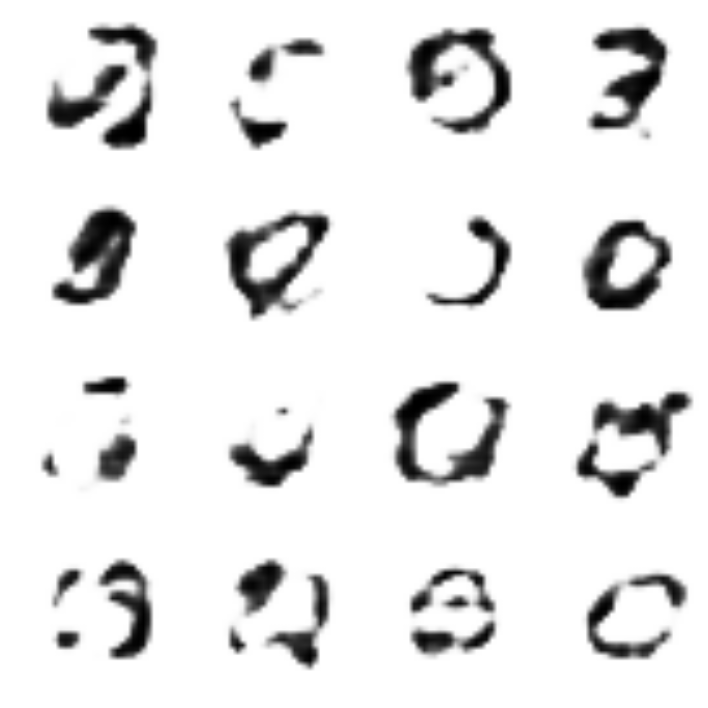

 33%|███▎      | 1999/6000 [32:57<1:05:12,  1.02it/s]

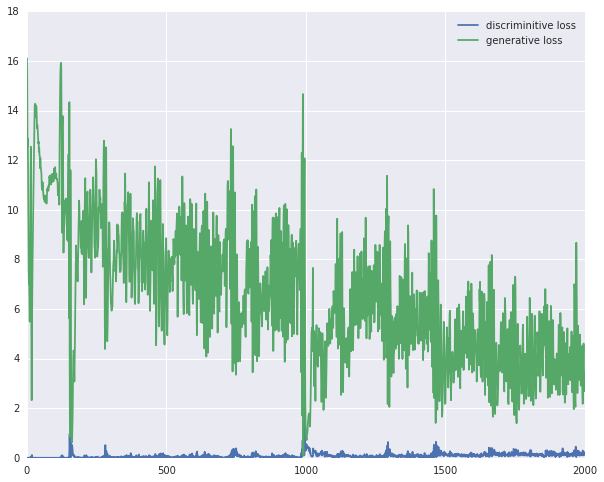

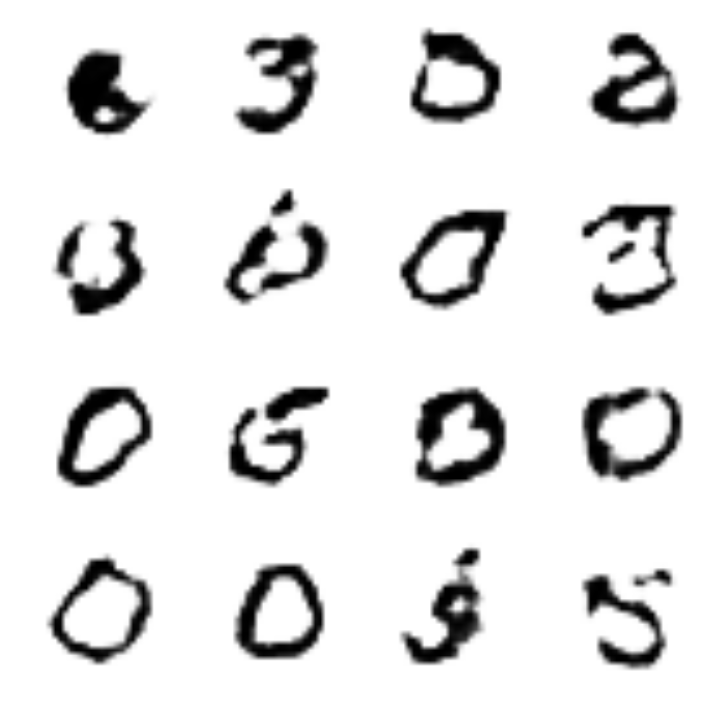

 50%|████▉     | 2999/6000 [50:02<49:50,  1.00it/s]

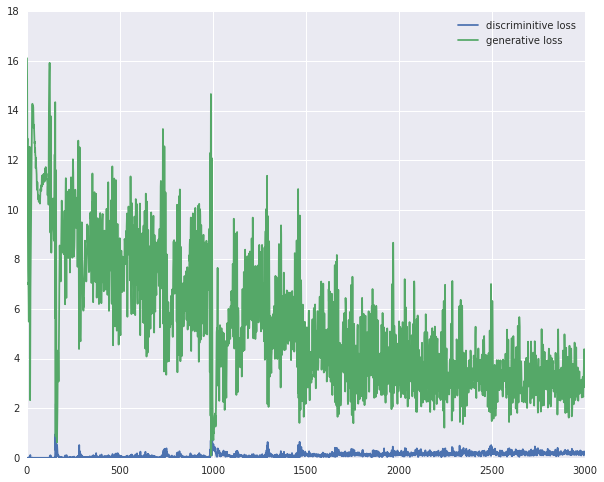

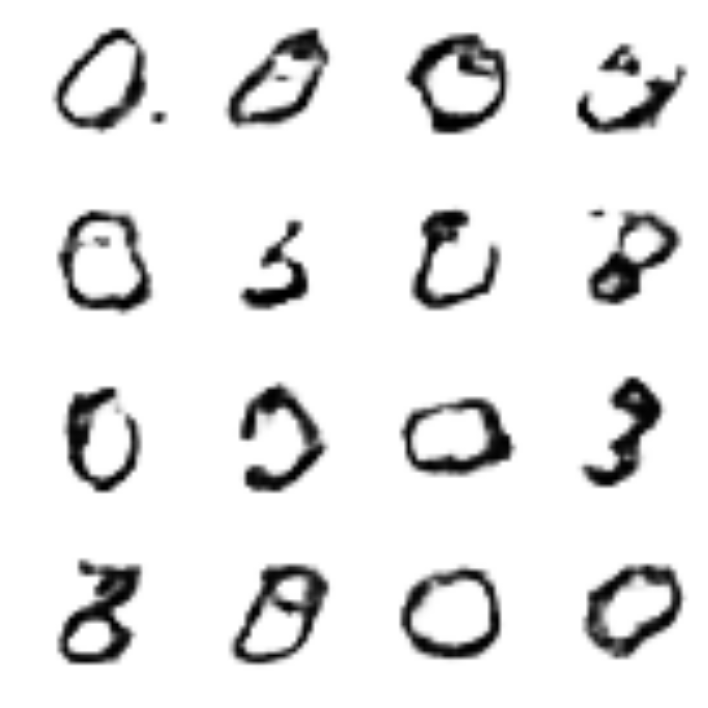

 67%|██████▋   | 3999/6000 [1:06:58<33:40,  1.01s/it]

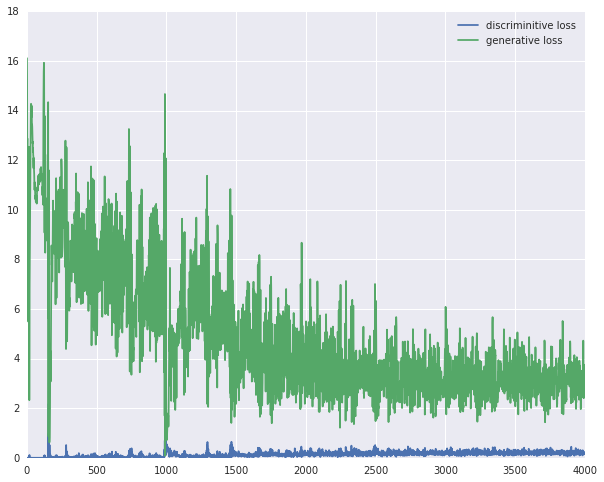

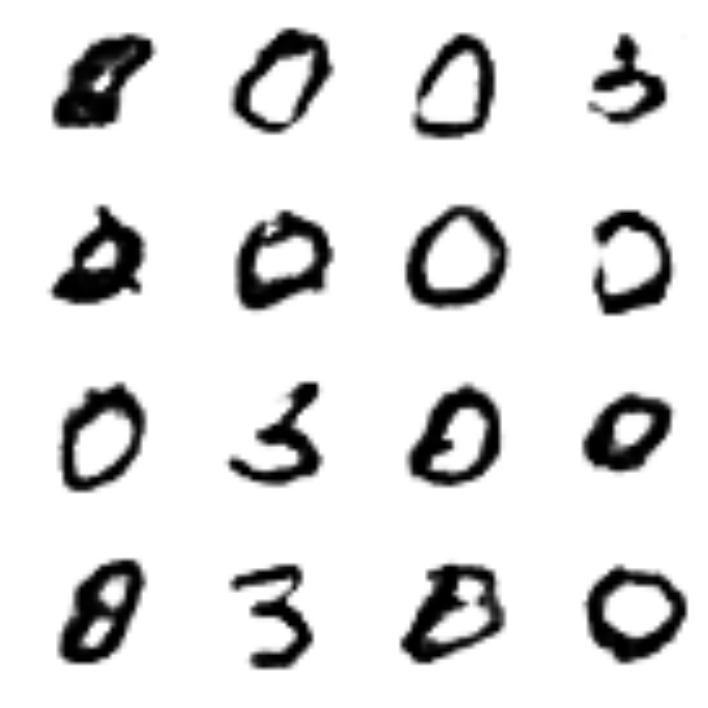

 83%|████████▎ | 4999/6000 [1:23:55<16:58,  1.02s/it]

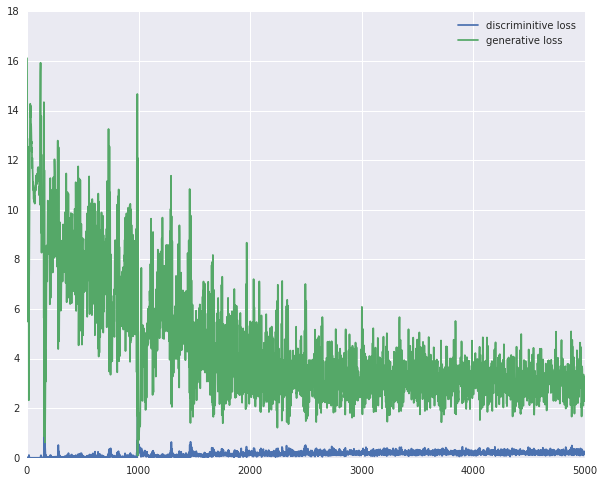

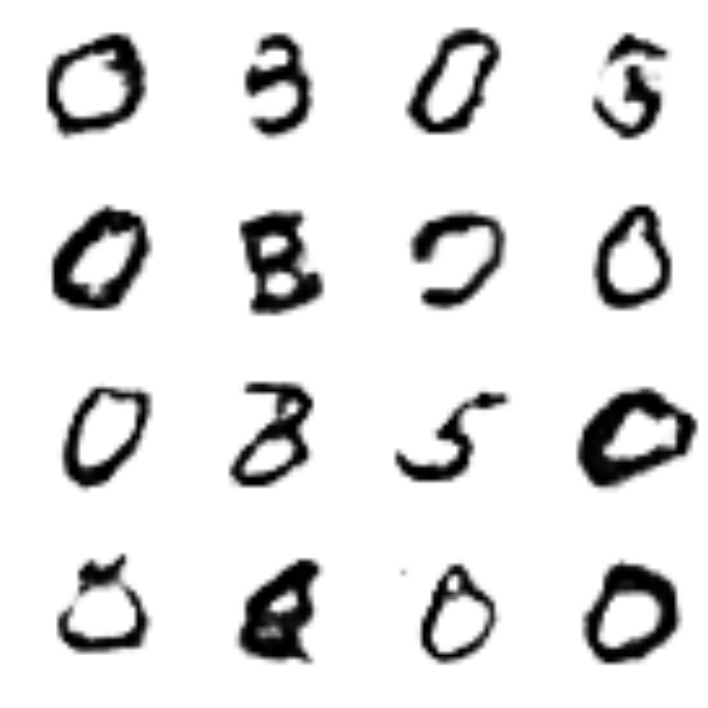

100%|█████████▉| 5999/6000 [1:40:42<00:00,  1.04it/s]

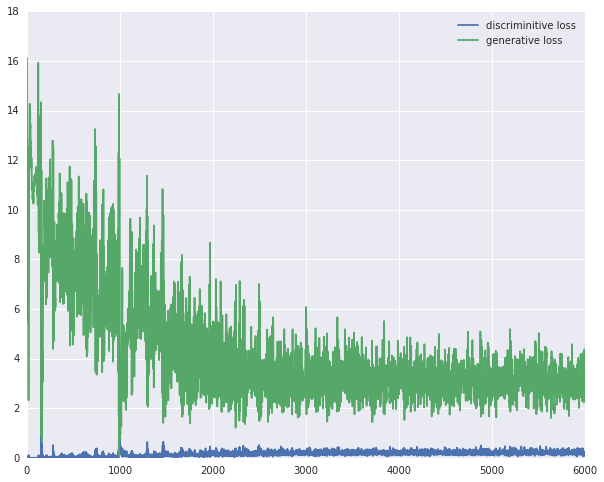

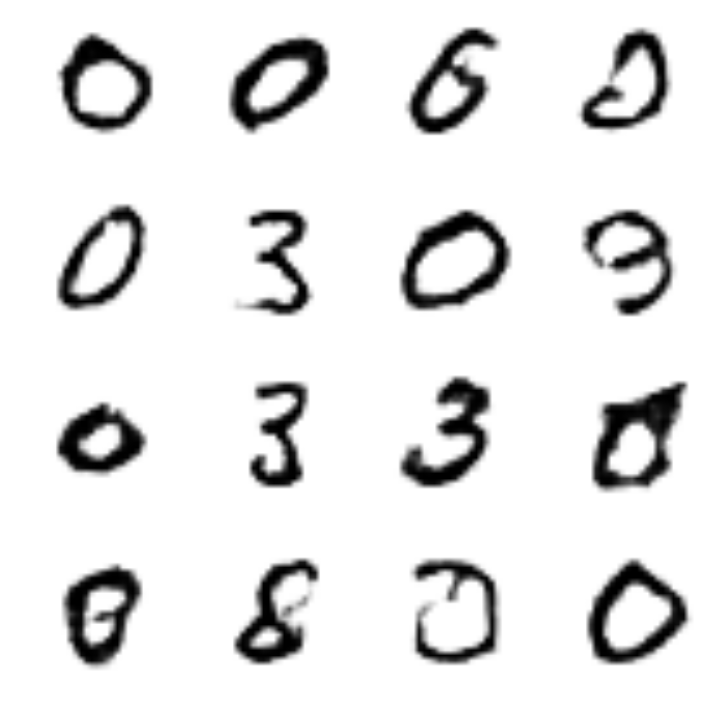

100%|██████████| 6000/6000 [1:40:44<00:00,  1.45s/it]


In [1]:
# Keras GAN Implementation
# See: https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/
#
%matplotlib inline

import keras
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
from keras import backend as K
K.set_image_dim_ordering('th')

import os,random
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
from keras.models import Model
#from IPython import display
from keras.utils import np_utils
from tqdm import tqdm

img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#temporary step to make data set smaller
#X_train = X_train[0:6000]
#X_test = X_test[0:1000]
#y_train = y_train[0:6000]
#y_test = y_test[0:1000]

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# disregards the first dimension, gives 1x28x28 instead of 60000x1x28x28
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

# Build Generative model ...

# NB: With the functional API, it is easy to re-use trained models: you can treat any model as if it were a layer, 
# by calling it on a tensor. Note that by calling a model you aren't just re-using the architecture of the model, 
# you are also re-using its weights:
# https://keras.io/getting-started/functional-api-guide/

nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch/2, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
# The input to the model is g_input and the output is g_V
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)

# Build stacked GAN model
# H is the output of the generator
# gan_V takes the output of the generator and build a discriminator on top
# This is all built into a model called "GAN"
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

def plot_loss(losses):
#        display.clear_output(wait=True)
#        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# define number of data points we want to use
ntrain = 10000
# create ntrain random values of the total range, in this case this is 10.000 random integers from 60.000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
# extract the 10.000 random training examples from our data set
XT = X_train[trainidx,:,:,:]

#-------------------- Pre-train the discriminator network ---------------------------

# Generate 10.000 random vectors of length 100. These 10.000 samples with 100 features are 
# used in the generator to generate fake images. At this point these fake images are
# totally random. They are used to pre-train the discriminator. 
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
# use the 10.000 noise vectors to generate noise pictures
generated_images = generator.predict(noise_gen)
# merge the fake and real pictures
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
# create labels for the 2*n pictures
# the first n data points are real pictures and have labels [0,1]
# the last n data points are fake and have labels [1,0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

# Change the discriminator such that all parameters are now trainable
make_trainable(discriminator,True)
#discriminator.fit(X,y, nb_epoch=1, batch_size=1000)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)

# Measure accuracy of pre-trained discriminator network
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

# set up loss storage vector
losses = {"d":[], "g":[]}

# Set up our main training loop
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):
    # tqdm() prints the progress bar
    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        # select 32 random images from X_train
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        # create 32 random vectors of length 100
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        # generate 32 images from vectors
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        # we set the labels to [0,1] since we want the generator to train itself to look
        # like real images which have labels [0,1]!
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
        

# Train for 6000 epochs at original learning rates
train_for_n(nb_epoch=6000, plt_frq=1000,BATCH_SIZE=32)

 25%|██▍       | 499/2000 [08:16<23:41,  1.06it/s]

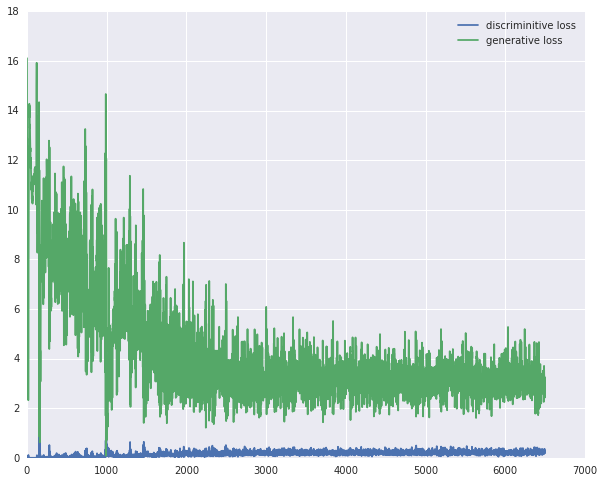

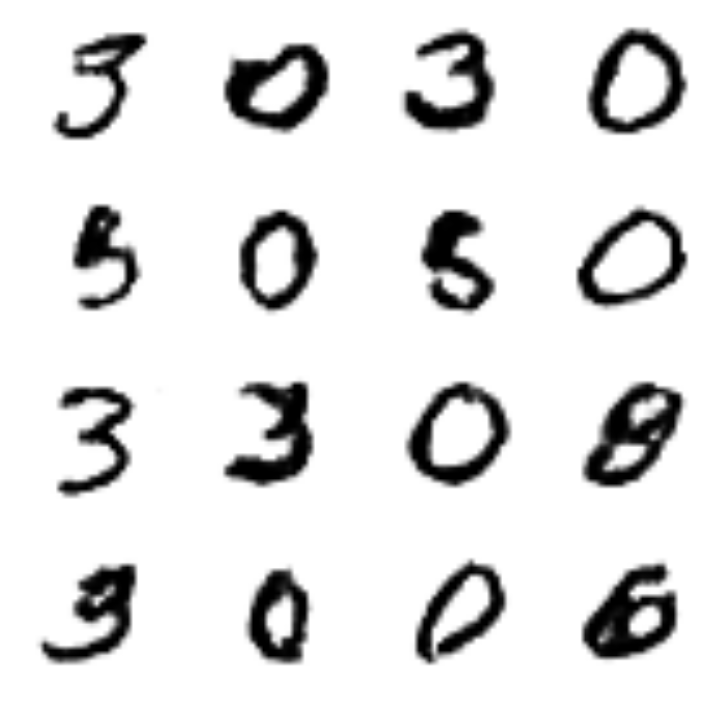

 50%|████▉     | 999/2000 [16:38<16:52,  1.01s/it]

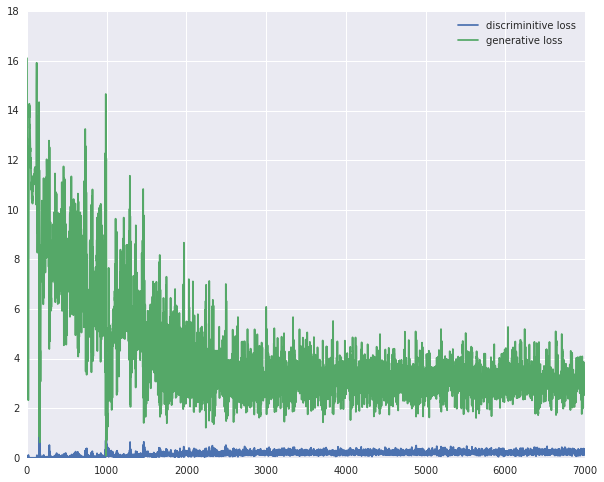

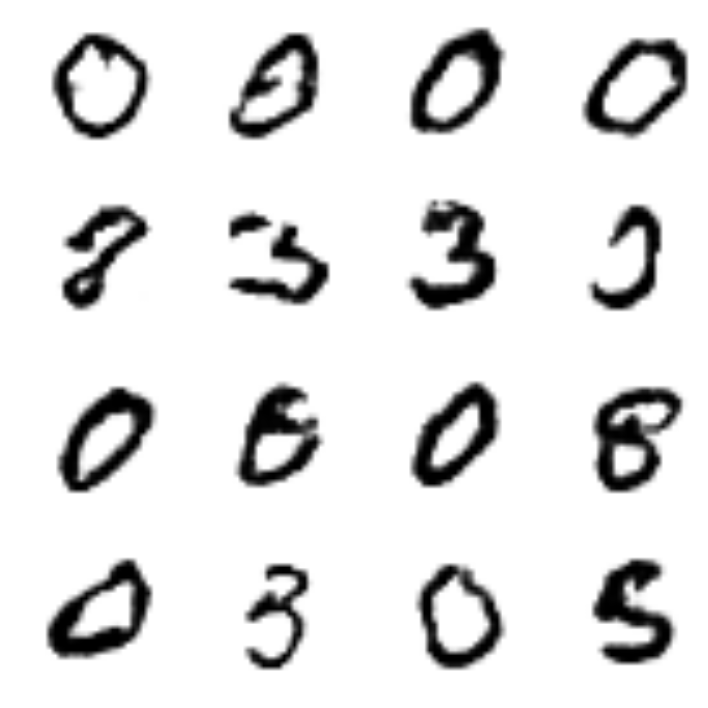

 75%|███████▍  | 1499/2000 [24:53<08:09,  1.02it/s]

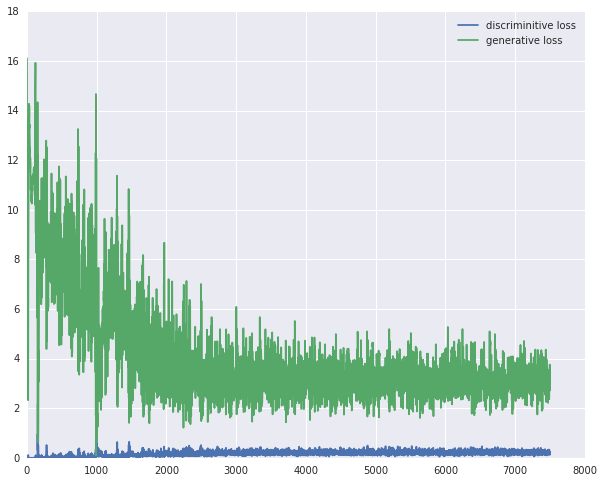

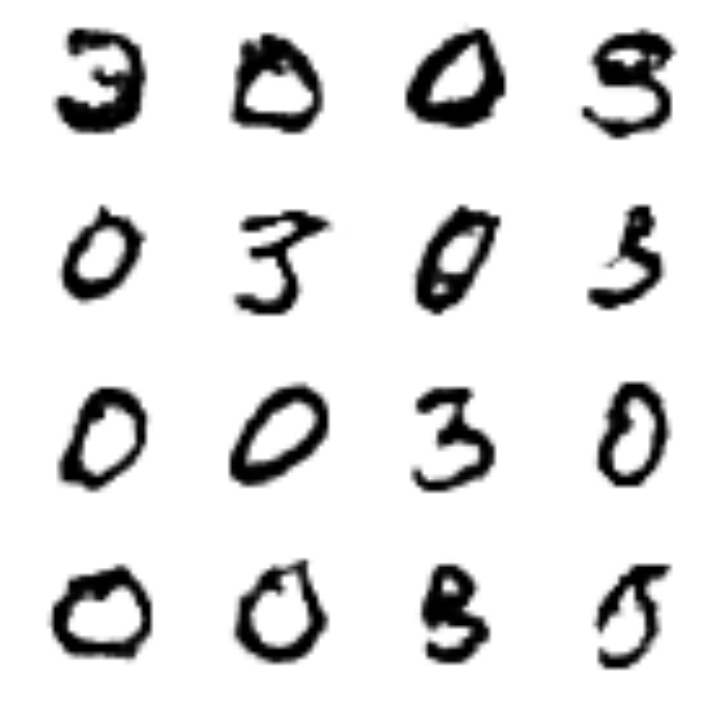

100%|█████████▉| 1999/2000 [33:18<00:00,  1.00it/s]

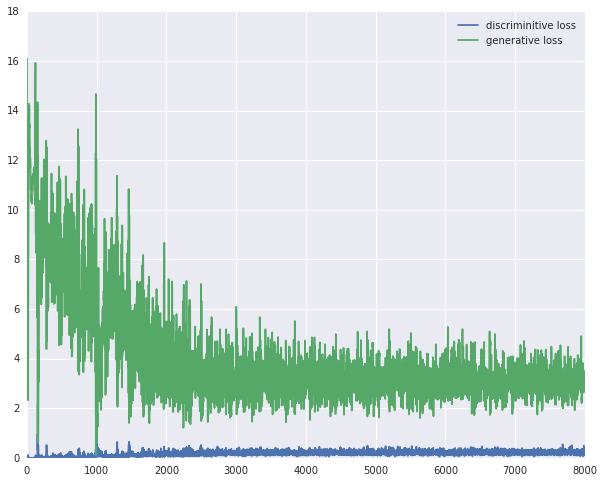

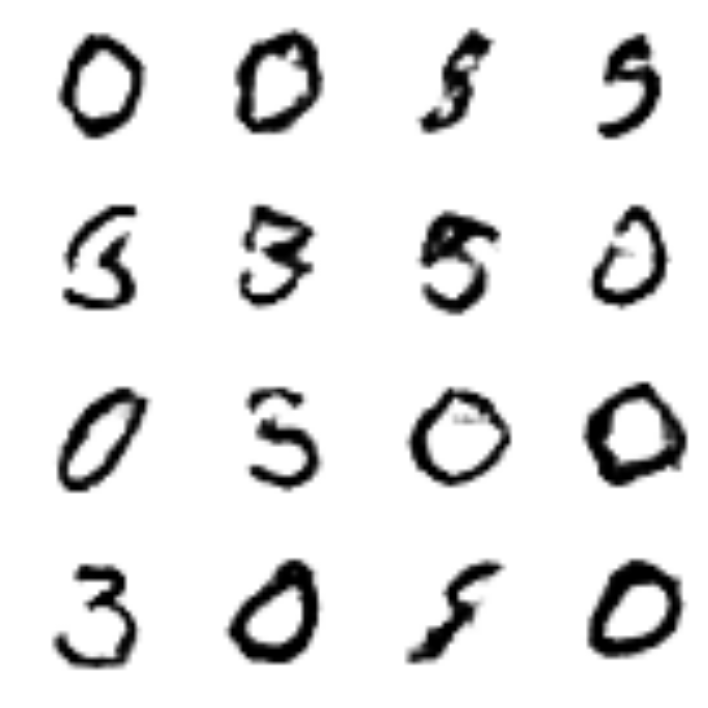

100%|██████████| 2000/2000 [33:21<00:00,  1.63s/it]


In [2]:
# Train for 2000 epochs at reduced learning rates
opt.lr.assign(1e-5)
dopt.lr.assign(1e-4)
#opt.lr.set_value(1e-5)
#dopt.lr.set_value(1e-4)
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)


 25%|██▍       | 499/2000 [08:24<24:25,  1.02it/s]

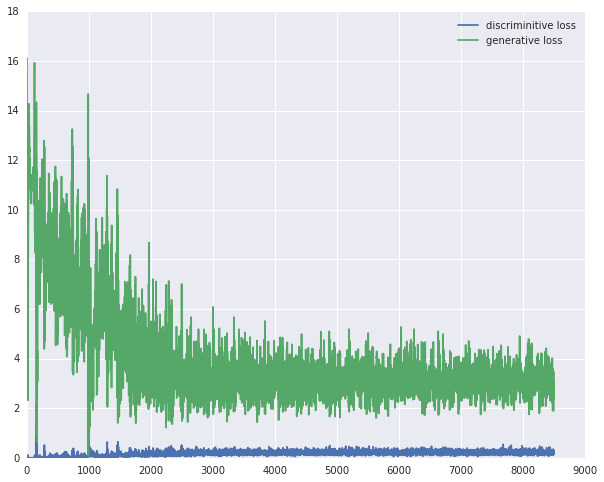

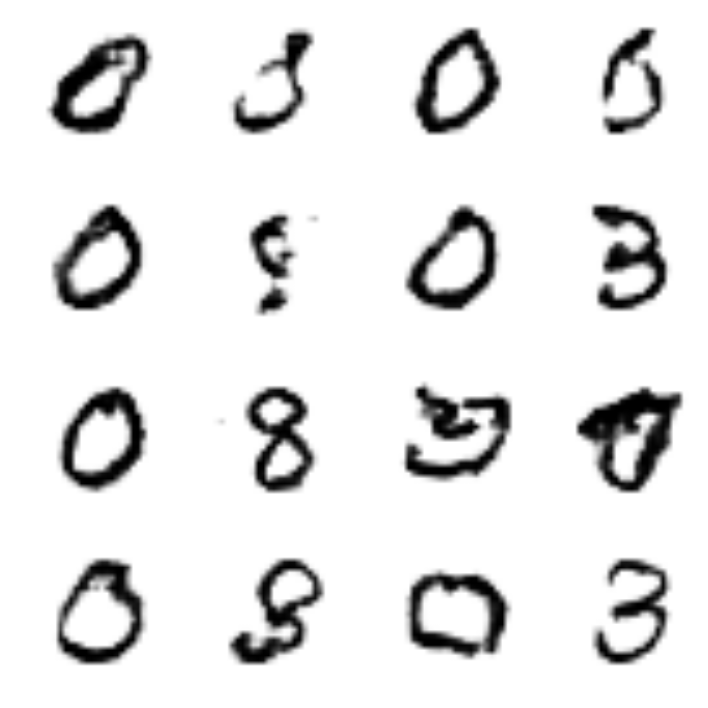

 50%|████▉     | 999/2000 [16:37<16:39,  1.00it/s]

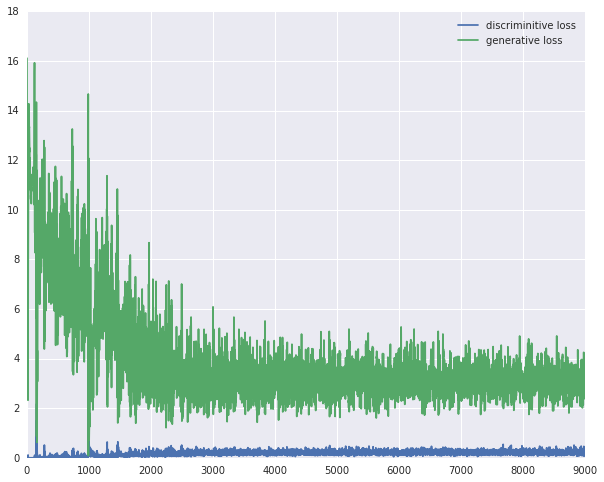

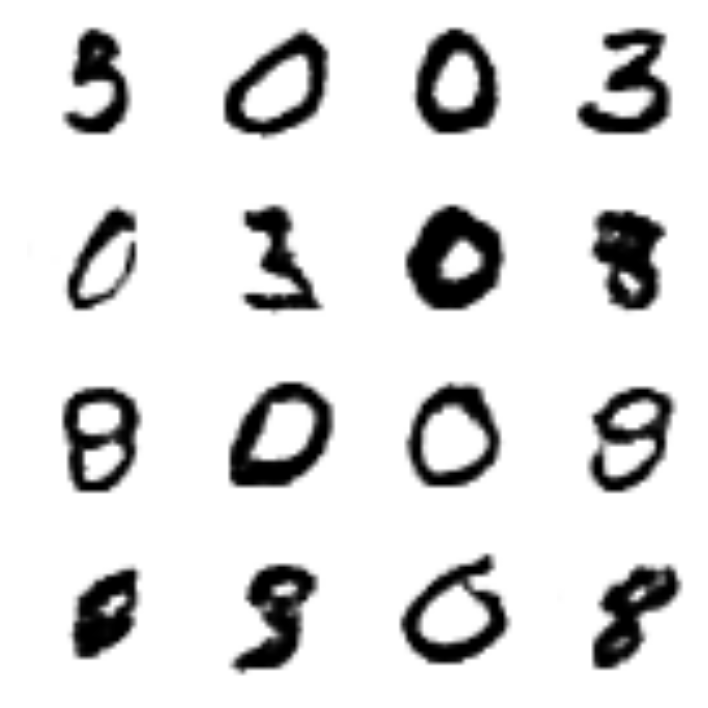

 75%|███████▍  | 1499/2000 [24:51<07:58,  1.05it/s]

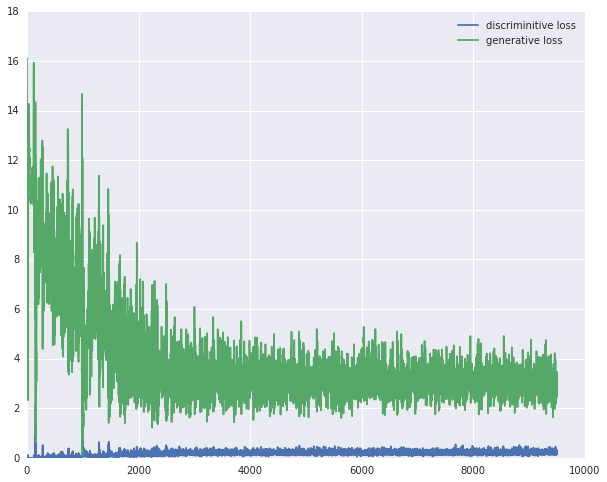

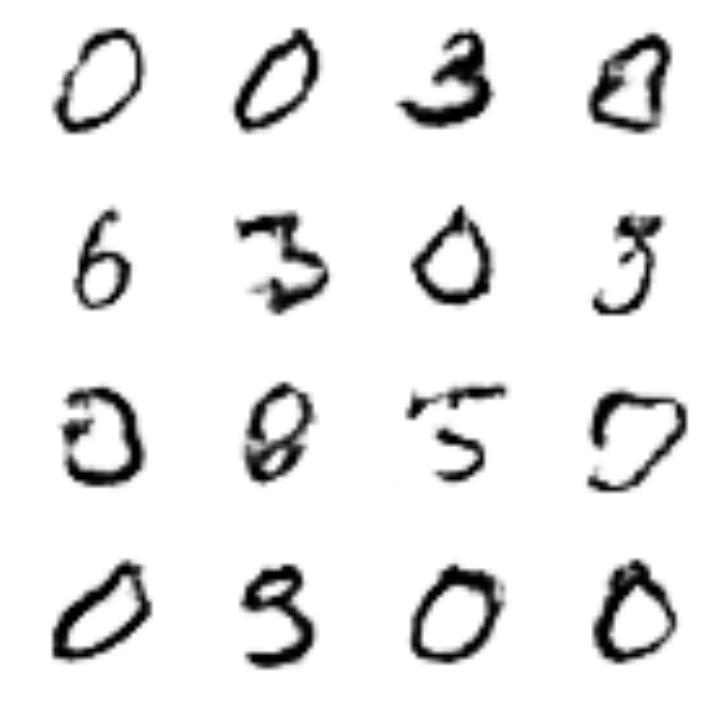

100%|█████████▉| 1999/2000 [33:03<00:00,  1.04it/s]

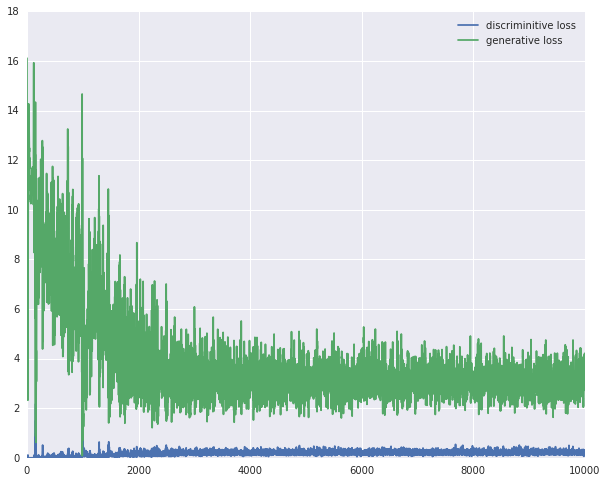

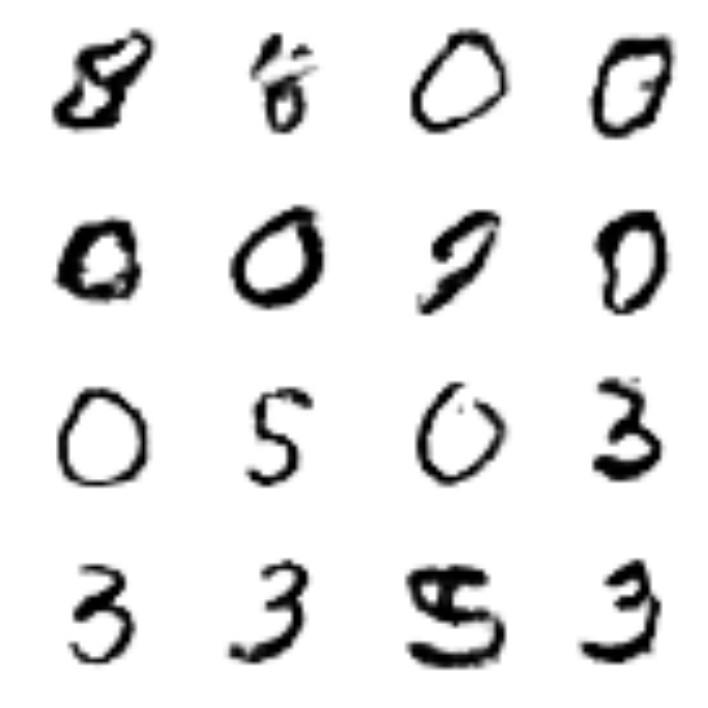

100%|██████████| 2000/2000 [33:05<00:00,  1.45s/it]


In [3]:
# Train for 2000 epochs at reduced learning rates
opt.lr.assign(1e-6)
dopt.lr.assign(1e-5)
#opt.lr.set_value(1e-6)
#dopt.lr.set_value(1e-5)
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)

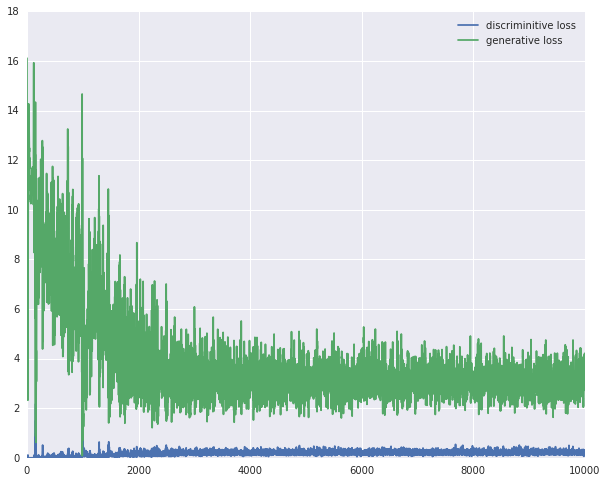

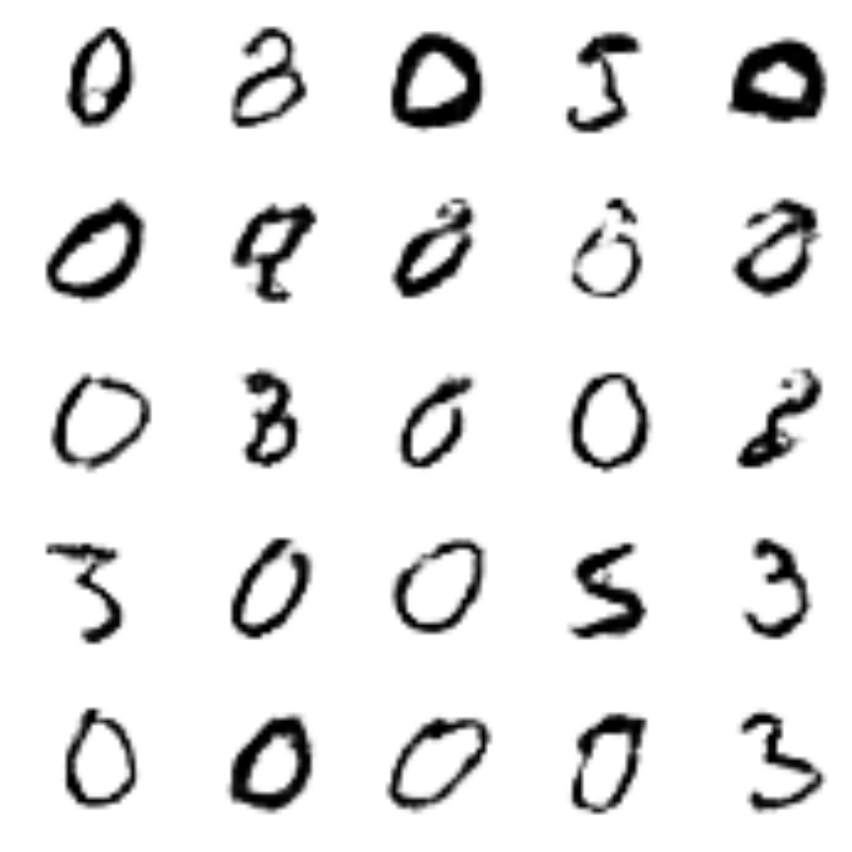

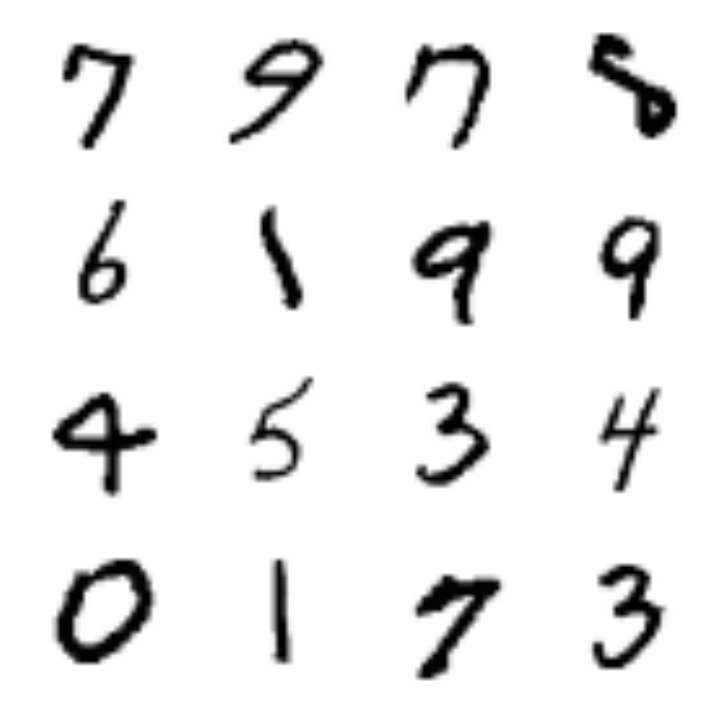

In [4]:
# Plot the final loss curves
plot_loss(losses)

# Plot some generated images from our GAN
plot_gen(25,(5,5),(12,12))

def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot real MNIST images for comparison
plot_real()
